# Advanced Neural Networks: Deep Learning for Spatial Analysis
# Assignment #1 - Object Classification Assignment: Diseased vs. Non-Diseased Leaf
# Rhichard Koh

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

In [2]:
# Define data directories
train_dir = './training_set'
val_dir = './validation_set'
test_dir = './test_set'

# Data Transforms
data_transforms = { # Initializes a dictionary called data_transforms to store different transformation pipelines for training ('train'), validation ('val'), and testing ('test') datasets.
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Randomly crops a portion of the image and resizes it to 224x224 pixels. 
        #This introduces randomness in the cropping process, which helps in data augmentation by providing varied perspectives of the images.
        transforms.RandomHorizontalFlip(), # Randomly flips the image horizontally with a default probability of 50%
        transforms.RandomRotation(40), # Randomly rotates the image by an angle between -40 and +40 degrees
        transforms.RandomAffine(0, shear=0.2, scale=(0.8, 1.2)), # Applies a random affine transformation with: 
        # Shear up to ±20%. Scaling between 80% and 120% of the original size.
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly adjusts the brightness and contrast of the image. The adjustments are made within ±20% of the original values.
        transforms.ToTensor(), # Converts the image to a PyTorch tensor. Scales pixel intensity values from [0, 255] to [0.0, 1.0].
        transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean
                             [0.229, 0.224, 0.225])   # ImageNet std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Resizes the image so that the shorter side is 256 pixels, maintaining the aspect ratio.
        transforms.CenterCrop(224), # Crops out the central 224x224 pixels of the resized image.
        transforms.ToTensor(), # Converts the image to a PyTorch tensor. Scales pixel values to the range [0.0, 1.0].
        transforms.Normalize([0.485, 0.456, 0.406], # ImageNet mean
                             [0.229, 0.224, 0.225]) # ImageNet std
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets
image_datasets = {
    # Creates image datasets using the hyperparameters stated in the data transforms dictionary.
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val'  : datasets.ImageFolder(val_dir, data_transforms['val']),
    'test' : datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Create Data Loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val'  : DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test' : DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def show_images_with_labels(dataloader, class_names, num_images=16):
    inputs, labels = next(iter(dataloader))
    inputs = inputs.cpu()
    labels = labels.cpu()

    plt.figure(figsize=(12, 12))
    for idx in range(num_images):
        ax = plt.subplot(4, 4, idx+1)
        image = inputs[idx]

        # Unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image.numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.imshow(image)
        label = labels[idx]
        class_name = class_names[label.item()]
        ax.set_title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

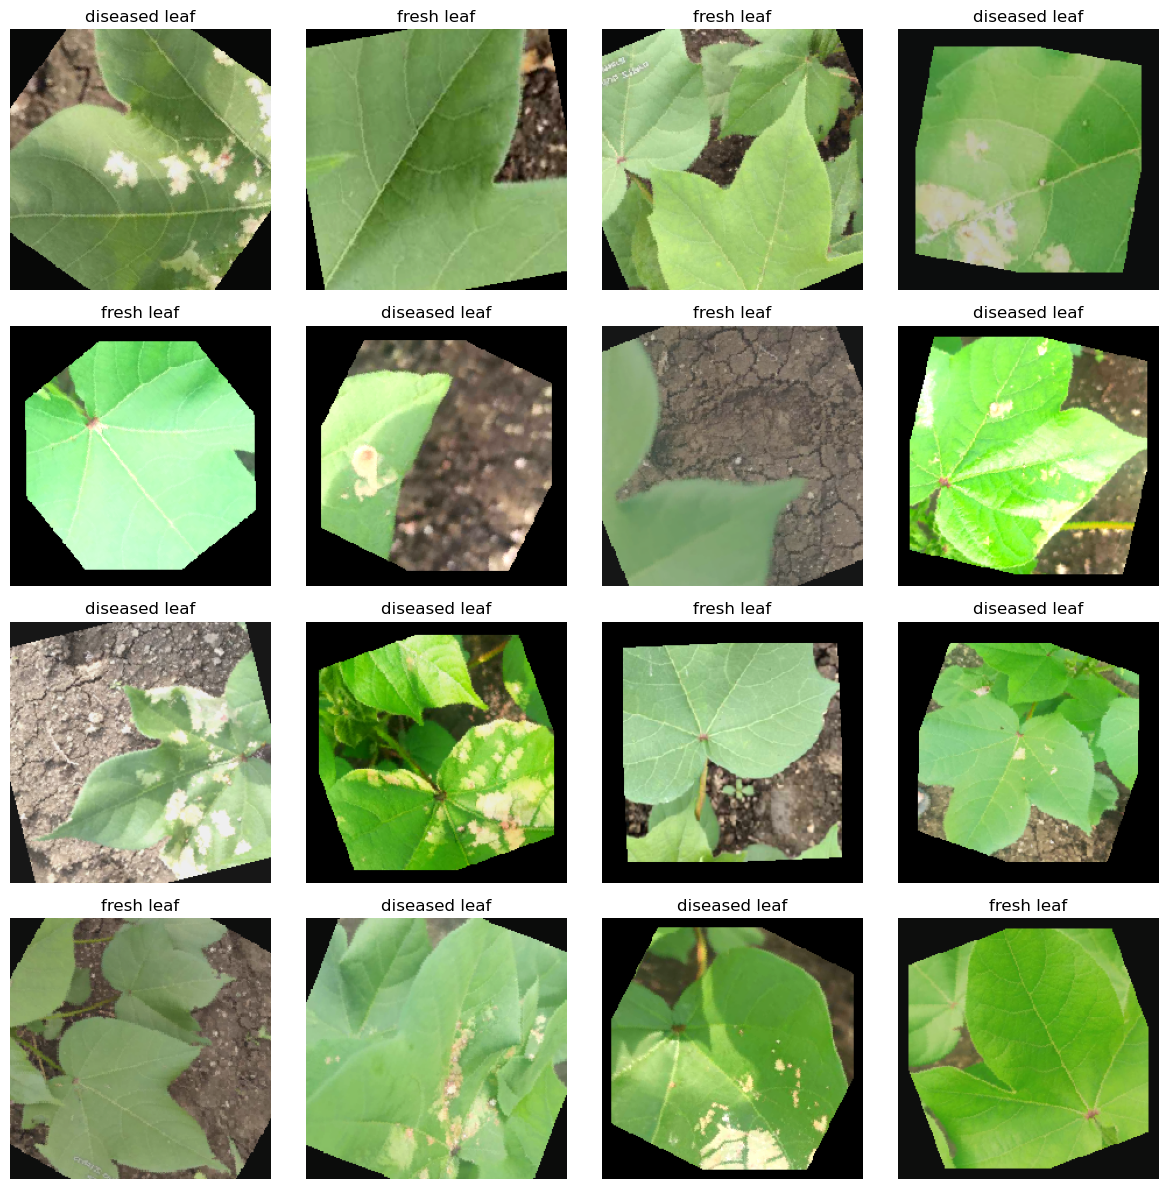

In [4]:
show_images_with_labels(dataloaders['train'], class_names, num_images=16)

In [5]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze the base model layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

model = model.to(device)

c:\Users\xxryk\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xxryk\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [7]:
from torch.optim import lr_scheduler

# Reduce LR on plateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-7)

In [8]:
import csv
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5, CSV_log=False):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    if CSV_log == True:
        with open("train_log.csv", mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['Phase', 'Epoch', 'Loss', 'Accuracy'])


    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.round(outputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc.cpu().numpy())
                val_loss_history.append(epoch_loss)
            
            if CSV_log == True:
                with open("train_log.csv", mode='a') as file:
                    writer = csv.writer(file)
                    writer.writerow([phase.capitalize(), epoch, float(epoch_loss), float(epoch_acc)])

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if validation loss decreases
            if phase == 'val':
                scheduler.step(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print('Early stopping!')
                        model.load_state_dict(best_model_wts)
                        return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

    print('Training complete')
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [9]:
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=25, patience=5, CSV_log=True)

Epoch 1/25
----------
Train Loss: 0.5884 Acc: 0.6825
Val Loss: 0.4690 Acc: 0.9037
Epoch 2/25
----------
Train Loss: 0.4076 Acc: 0.8531
Val Loss: 0.3481 Acc: 0.9111
Epoch 3/25
----------
Train Loss: 0.3399 Acc: 0.8951
Val Loss: 0.2932 Acc: 0.9185
Epoch 4/25
----------
Train Loss: 0.2830 Acc: 0.9007
Val Loss: 0.2586 Acc: 0.9259
Epoch 5/25
----------
Train Loss: 0.2375 Acc: 0.9273
Val Loss: 0.2503 Acc: 0.9185
Epoch 6/25
----------
Train Loss: 0.2449 Acc: 0.9105
Val Loss: 0.2265 Acc: 0.9259
Epoch 7/25
----------
Train Loss: 0.2590 Acc: 0.9021
Val Loss: 0.2436 Acc: 0.9185
Epoch 8/25
----------
Train Loss: 0.2112 Acc: 0.9231
Val Loss: 0.2504 Acc: 0.8889
Epoch 9/25
----------
Train Loss: 0.2452 Acc: 0.9091
Val Loss: 0.2189 Acc: 0.9259
Epoch 10/25
----------
Train Loss: 0.2310 Acc: 0.9119
Val Loss: 0.2364 Acc: 0.8963
Epoch 11/25
----------
Train Loss: 0.1839 Acc: 0.9287
Val Loss: 0.2310 Acc: 0.9259
Epoch 12/25
----------
Train Loss: 0.2109 Acc: 0.9189
Val Loss: 0.1902 Acc: 0.9185
Epoch 13/25
-

               precision    recall  f1-score   support

diseased leaf       1.00      1.00      1.00         3
   fresh leaf       1.00      1.00      1.00         5

     accuracy                           1.00         8
    macro avg       1.00      1.00      1.00         8
 weighted avg       1.00      1.00      1.00         8



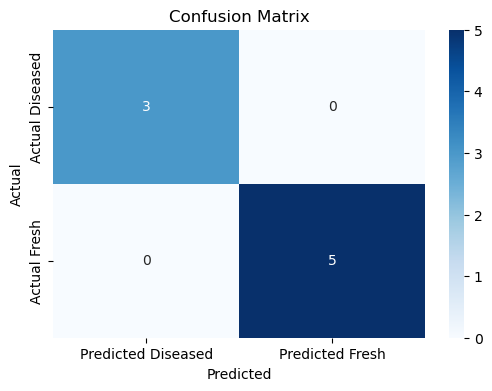

In [10]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Set model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(inputs)
        preds = torch.round(outputs)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Diseased', 'Predicted Fresh'],
            yticklabels=['Actual Diseased', 'Actual Fresh'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

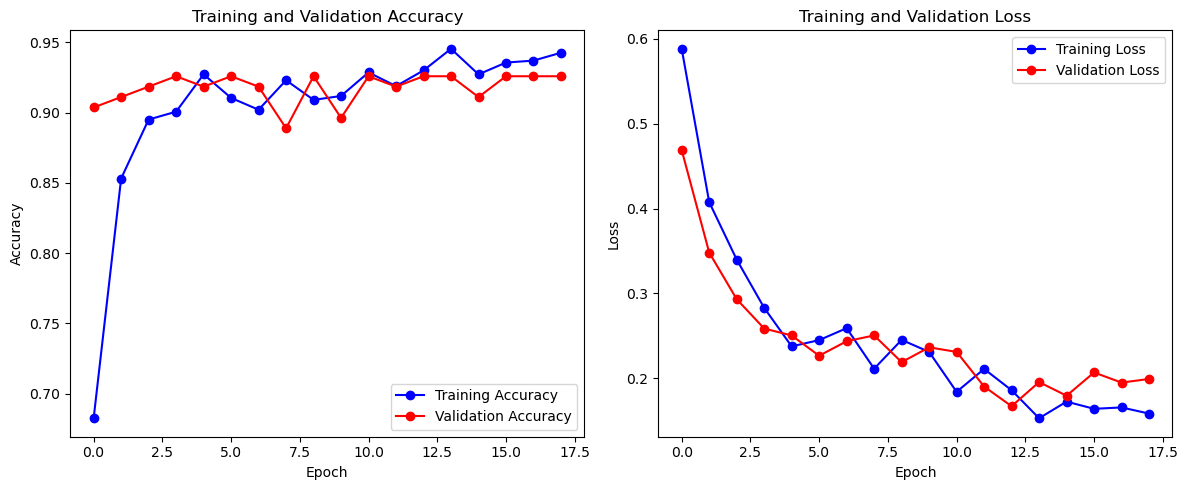

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, 'bo-', label='Training Accuracy')
plt.plot(val_acc_history, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, 'bo-', label='Training Loss')
plt.plot(val_loss_history, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def predict(model, dataloader):
    model.eval()  # Set model to evaluate mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.round(outputs)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()  # Set model to evaluate mode
    images_so_far = 0
    plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.round(outputs)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[int(preds[i].item())]}, \nTrue: {class_names[int(labels[i].item())]}', 
                             color=("black" if class_names[int(preds[i].item())] == class_names[int(labels[i].item())] else "red"))
                img = inputs.cpu().data[i]
                img = img.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean  # Unnormalize
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.show()
                    return
        plt.show()


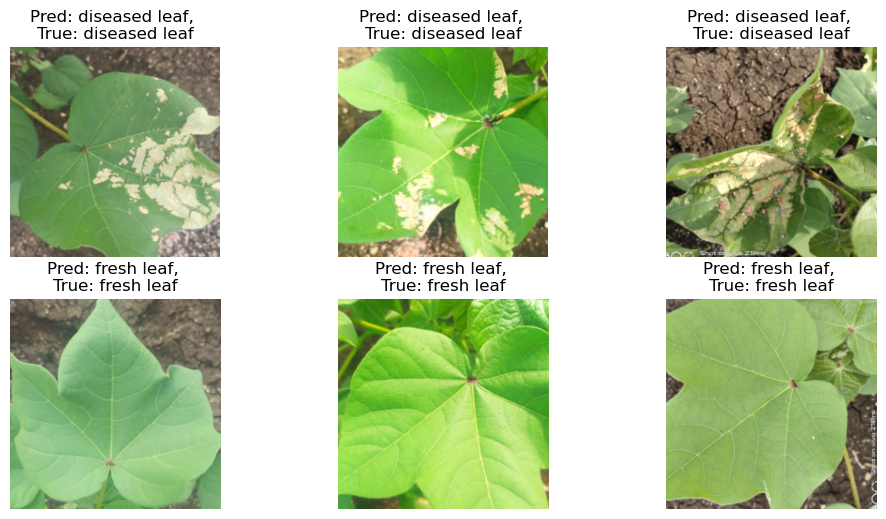

In [13]:
model.load_state_dict(torch.load('best_model.pth'))

# Assuming you have a class_names dictionary
class_names = image_datasets['test'].classes

# Make predictions on the test set
test_predictions, test_true_labels = predict(model, dataloaders['test'])

# Visualize predictions on the test set
visualize_predictions(model, dataloaders['test'], class_names, num_images=6)


In [14]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict_single_image(model, image_path, transform):
    model.eval()  # Set model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Move the input to the appropriate device
    input_batch = input_batch.to(device)

    with torch.no_grad():
        output = model(input_batch)
        pred = torch.round(output)
        probability = torch.sigmoid(output)  # If using sigmoid activation

    return probability.item(), int(pred.item())

def visualize_single_image_prediction(model, image_path, transform, class_names):
    # Get the prediction
    probability, pred_label = predict_single_image(model, image_path, transform)

    # Load the image without transformations for display
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6, 4))
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_label]} (Prob: {probability:.2f})')
    
    # Display the image
    plt.imshow(image)
    plt.show()

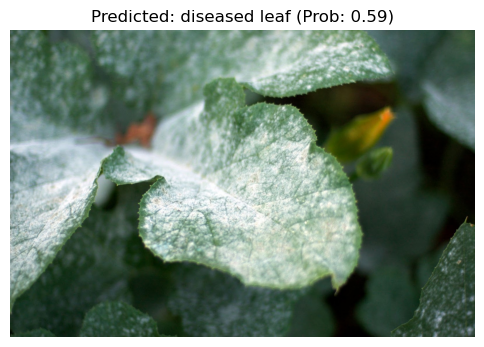

In [15]:
from torchvision import transforms

model.load_state_dict(torch.load('best_model.pth'))

# Define the same transformations as used for validation/testing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
class_names = image_datasets['test'].classes

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

image_path = 'test3.jpg'

# Predict and visualize
visualize_single_image_prediction(model, image_path, transform, class_names)
